# Assignment 2 - Spark Dataframes
***Note***: All the dataset files were stored in the same folder as this notebook.

## Dependencies

### JDK 8

Download link: https://www.oracle.com/java/technologies/javase/javase8-archive-downloads.html

You will need to create an account and sign-in in order to download it.

Press start and search for "Edit environment variables for your account"

Click new and add 'JAVA_HOME' with the path for your java jdk folder e.g. C:\Program Files\Java\jdk1.8.0_202 and add 'JRE_HOME' with the path for your java jre folder e.g. C:\Program Files\Java\jre1.8.0_361

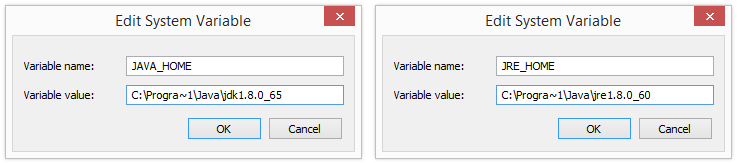

### PySpark
PySpark installation using PyPI is as follows:
```python
pip install pyspark
pip install pyarrow
```
If you want to install extra dependencies for a specific component, you can install it as below:
```bash
# Spark SQL
pip install pyspark[sql]
# pandas API on Spark
pip install pyspark[pandas_on_spark] plotly  # to plot your data, you can install plotly together
```
More info about about installing PySpark: [PySpark Installation Guide](https://spark.apache.org/docs/latest/api/python/getting_started/install.html#using-pypi)

### Haversine
```
pip install haversine
```

More info about about Haversine: https://pypi.org/project/haversine/

In [4]:
import os
import pyspark
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
conf = pyspark.SparkConf()
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)
spark

## 1. 15 Points
**Datafile**: BreadBasket_DMS.csv

**Solve**: What is the most popular (most sold) between the 8:00AM and 8:59AM for each day?

Example output (not actual solution)

    2016-10-30, Pastry

    2016-10-31, Coffee
     :
     :

### Approach:
1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
3. Filter the data by `Time` in the range of `08:00:00` and `08:59:00` inclusive
4. Group the data by `Date` and `Item`, aggregate by the `count` and, sort by `Date` and `count`
5. Group the data by `Date` and return the `last` `Item` and `last` `count`

In [1]:
# 1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
from pyspark.sql.functions import col
BreadBasket_DMS = spark.read.option("header", True).option("InferSchema", True).csv("BreadBasket_DMS.csv")
BreadBasket_DMS = BreadBasket_DMS.filter(col("Item") != "NONE")

# 2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
from pyspark.sql.functions import to_date, date_format
BreadBasket_DMS = BreadBasket_DMS.withColumn("Date", to_date(col("Date"), "YYYY-MM-DD"))
BreadBasket_DMS = BreadBasket_DMS.withColumn("Time", date_format(col("Time"),"hh:mm:ss"))

# 3. Filter the data by `Time` in the range of `08:00:00` and `08:59:00` inclusive 
q1 = BreadBasket_DMS
q1 = q1.filter((col("Time") <= "08:59:00") & (col("Time") >= "08:00:00"))

# 4. Group the data by `Date` and `Item`, aggregate by the `count` and, sort by `Date` and `count`
q1 = q1.groupBy("Date","Item").count().sort("Date","count")

# 5. Group the data by `Date` and return the last `Item` and last `count`
from pyspark.sql.functions import last
q1 = q1.groupBy("Date").agg(last("Item").alias("Most Popular Iteam"),last("count").alias("Total Transactions"))

# Display results
print("List of the most popular (most sold) items between the 8:00 AM and 8:59 AM for each day and their total transactions that day:")
q1.show()

NameError: name 'spark' is not defined

## 2. 15 Points
**Datafile**: BreadBasket_DMS.csv

**Solve**: What is the most common item bought along with “Brownie”? (items bought in the same transaction)

### Assumptions:
We will assume that we will count each time an item was bought with “Brownie”. If an item was bought more than once in the same transaction we will count each time that item was bought in that transaction.

### Approach:
1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
3. Create 2 lists of transactions: one with and one without “Brownie” in the `Item` column by using `filter()`
4. Use a `left_semi` join where the `Transaction` is the same only keeping items bought with “Brownie”
5. Group the data by `Item`, aggregate by `count()` of the data and, sort the data by `count` in descending order

In [3]:
# 1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
from pyspark.sql.functions import col
BreadBasket_DMS = spark.read.option("header", True).option("InferSchema", True).csv("BreadBasket_DMS.csv")
BreadBasket_DMS = BreadBasket_DMS.filter(col("Item") != "NONE")

# 2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
from pyspark.sql.functions import to_date, date_format
BreadBasket_DMS = BreadBasket_DMS.withColumn("Date", to_date(col("Date"), "YYYY-MM-DD"))
BreadBasket_DMS = BreadBasket_DMS.withColumn("Time", date_format(col("Time"),"hh:mm:ss"))

# 3. Create 2 lists of transactions: one with and one without “Brownie” in the `Item` column by using `filter()`
BrownieTransactions = BreadBasket_DMS.filter(col("Item") == "Brownie").sort("Transaction")
OtherTransactions = BreadBasket_DMS.filter(col("Item") != "Brownie")

# 4. Use a `left_semi` join where the `Transaction` is the same only keeping items bought with “Brownie”
JoinExpression = BrownieTransactions["Transaction"] == OtherTransactions["Transaction"]
ItemBougtWithBrownie = OtherTransactions.join(BrownieTransactions,JoinExpression, "left_semi").sort("Transaction")

# 5. Group the data by `Item`, aggregate by `count()` of the data and, sort the data by `count` in descending order
from pyspark.sql.functions import desc
print("List of the most common items bought along with “Brownie” sorted by their counts")
ItemBougtWithBrownie.groupBy("Item").count().sort(desc("count")).show()

List of the most common items bought along with “Brownie” sorted by their counts
+-----------------+-----+
|             Item|count|
+-----------------+-----+
|           Coffee|  237|
|            Bread|  115|
|              Tea|   71|
|             Cake|   43|
|    Hot chocolate|   42|
|         Sandwich|   27|
|        Alfajores|   27|
|          Cookies|   26|
|            Juice|   24|
|           Pastry|   23|
|        Medialuna|   19|
|           Muffin|   18|
|             Soup|   15|
|            Scone|   12|
|             Coke|   11|
|       Farm House|   11|
|         Truffles|   11|
|    Mineral water|    9|
|            Toast|    7|
|Hearty & Seasonal|    6|
+-----------------+-----+
only showing top 20 rows



## 3. 10 Points
**Datafile**: Restaurants_in_Durham_County_NC.csv

__NOTE*** This file is colon delimited (not comma) ***__

**Solve**: How many years are represented in this dataset?

Inspecting the Restaurants_in_Durham_County_NC.csv file, I noticed that there several line breaks in the file that cause PySpark to think that this is a new row. Here is an example of this:

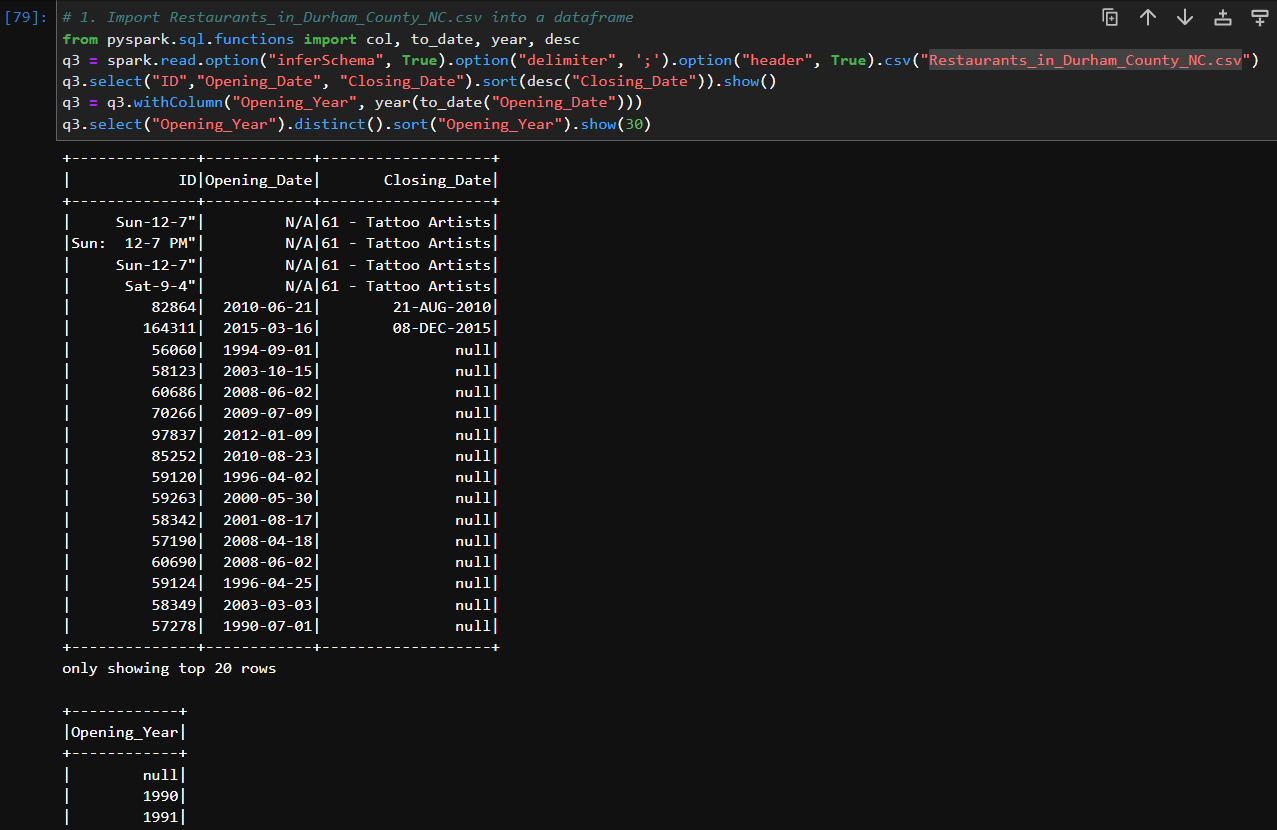
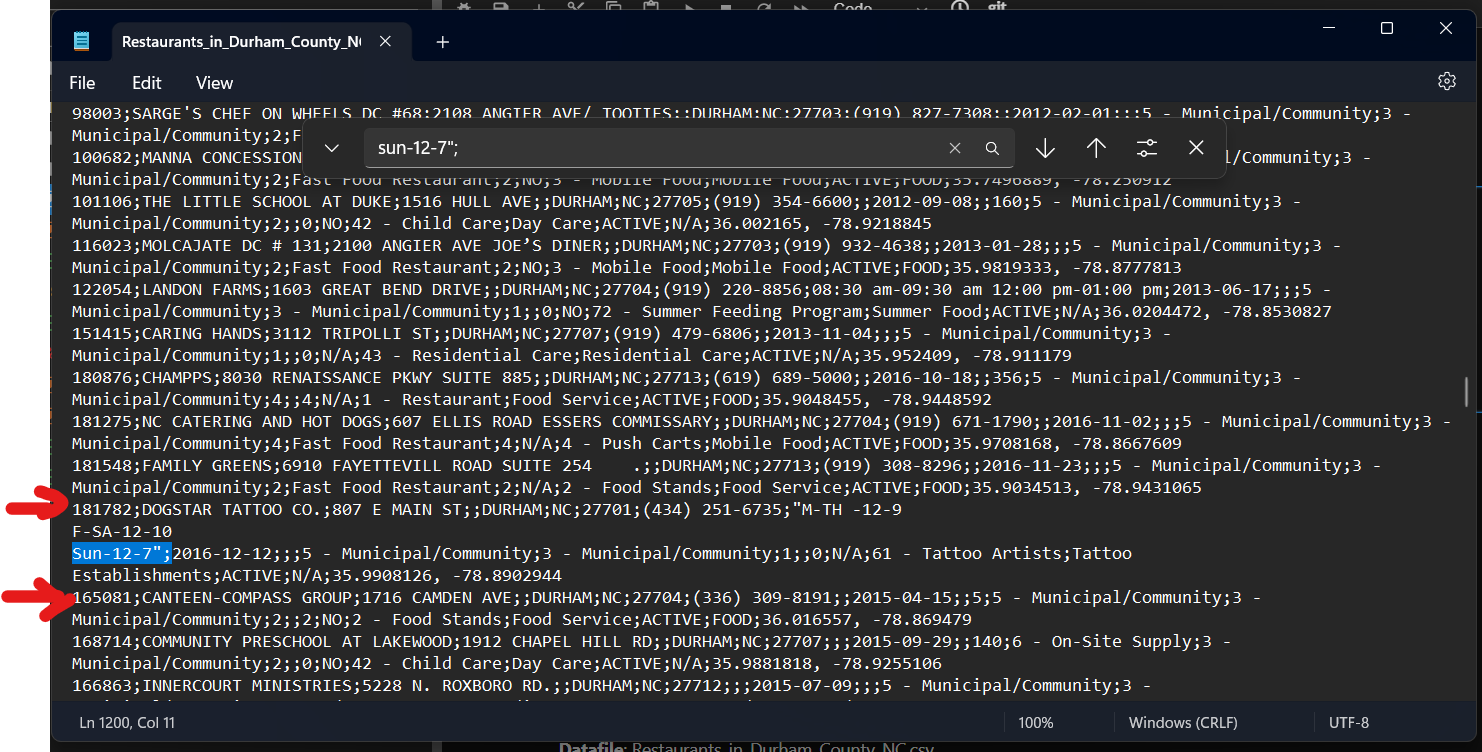
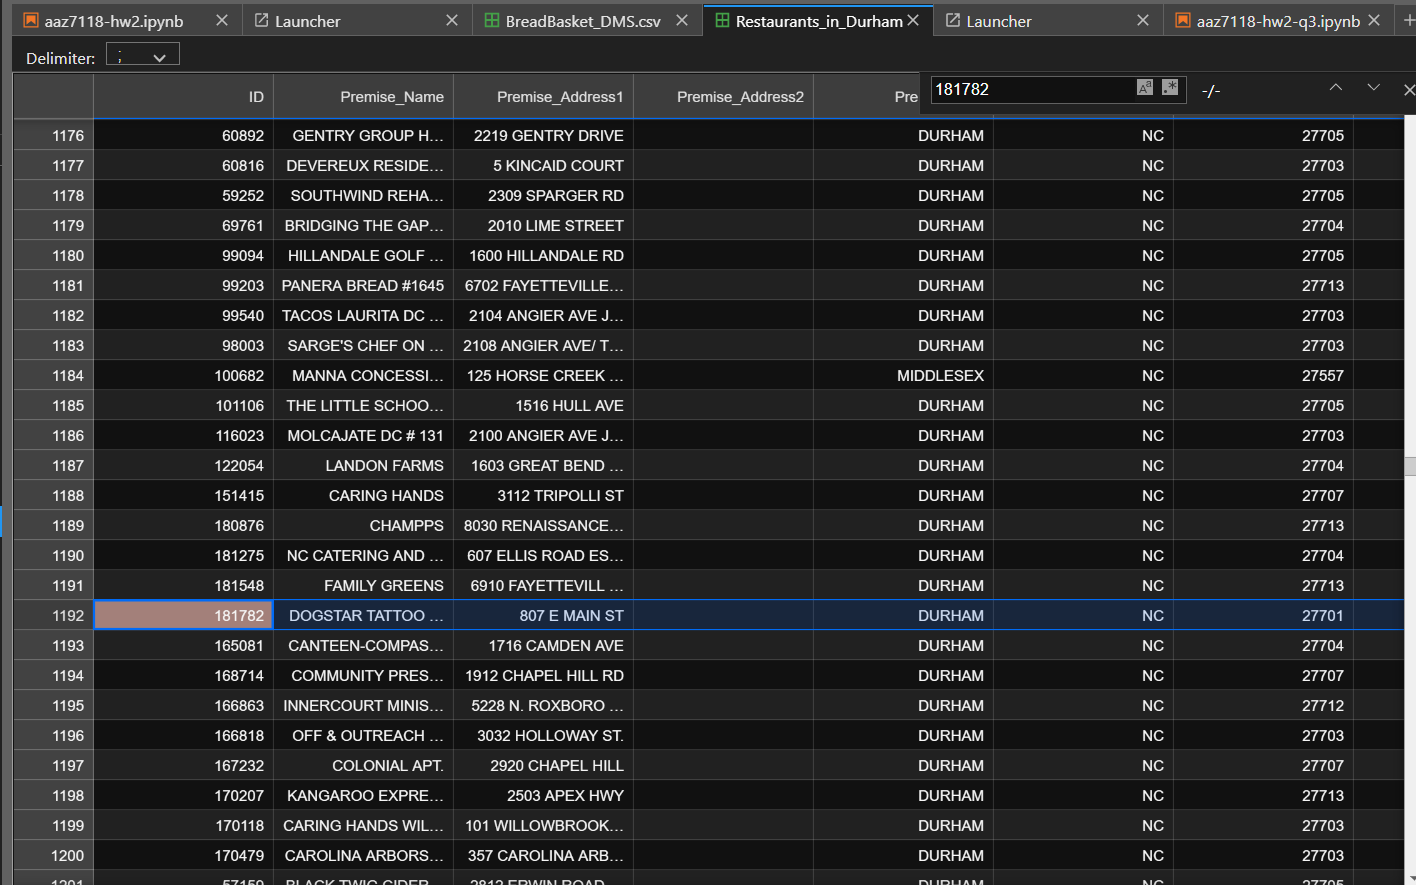

To fix this, I used `.option("multiline",True)`

Source: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read

### Approach:
1. Import `Restaurants_in_Durham_County_NC` into a dataframe
2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
3. Select the `Opening_Year` column, keep only unique items and, sort by `Opening_Year`
4. Display the result. Extracting single value from DataFrame: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/

In [39]:
# 1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
# Source for reading csv files with multiline: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read
Restaurants = spark.read\
.option("inferSchema", True)\
.option("delimiter", ';')\
.option("header", True)\
.option("multiline", True)\
.csv("Restaurants_in_Durham_County_NC.csv")

# 2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
from pyspark.sql.functions import col, to_date, year
Restaurants = Restaurants.withColumn("Opening_Year", year(to_date("Opening_Date")))

# 3. Select the `Opening_Year` column, keep only unique items and, sort by `Opening_Year`
Years = Restaurants.select("Opening_Year").distinct().sort("Opening_Year")

# 4. Display the results
# Extracting single value from DataFrame: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/
from pyspark.sql.functions import first, last
print("There are " + str(Years.count()) + " years are represented in this dataset. They span from " + str(Years.first()[0]) + " to " + str(Years.tail(1)[0][0]))
Years.show(Years.count())

There are 28 years are represented in this dataset. They span from 1990 to 2017
+------------+
|Opening_Year|
+------------+
|        1990|
|        1991|
|        1992|
|        1993|
|        1994|
|        1995|
|        1996|
|        1997|
|        1998|
|        1999|
|        2000|
|        2001|
|        2002|
|        2003|
|        2004|
|        2005|
|        2006|
|        2007|
|        2008|
|        2009|
|        2010|
|        2011|
|        2012|
|        2013|
|        2014|
|        2015|
|        2016|
|        2017|
+------------+



## 4. 20 Points
**Dataset**: Restaurants_in_Durham_County_NC.csv

**Solve**: Show the type and count of restaurant opened during the 90’s (1990-1999 inclusive). Note: type=”Rpt_Area_Desc”

Example (not the actual result):
  
    “Swimming Pools”,  13
  
    “Tatoo Establishment”,  2
  
     :
### Approach:
1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
3. Filter the `Opening_Year` column betwen 1990 and 1999 inclusive
4. Group by the column `Rpt_Area_Desc` and aggregate by `count`

In [40]:
from pyspark.sql.functions import col, to_date, year
# 1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
# Source for reading csv files with multiline: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read
Restaurants = spark.read\
.option("inferSchema", True)\
.option("delimiter", ';')\
.option("header", True)\
.option("multiline", True)\
.csv("Restaurants_in_Durham_County_NC.csv")

# 2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
from pyspark.sql.functions import col, to_date, year
Restaurants = Restaurants.withColumn("Opening_Year", year(to_date("Opening_Date")))

# 3. Filter the `Opening_Year` column betwen 1990 and 1999 inclusive 
q4 = Restaurants.filter((col("Opening_Year") <= 1999) & (col("Opening_Year") >= 1990))

# 4. Group by the column `Rpt_Area_Desc` and aggregate by `count`
q4 = q4.groupBy("Rpt_Area_Desc").count()

# Display the results
print("List of the type and count of restaurants opened during the 90’s (1990-1999 inclusive):")
q4.show()

List of the type and count of restaurants opened during the 90’s (1990-1999 inclusive):
+------------------+-----+
|     Rpt_Area_Desc|count|
+------------------+-----+
|Bed&Breakfast Home|    3|
|      Summer Camps|    1|
|      Institutions|   16|
| Local Confinement|    2|
|  School Buildings|   56|
|    Swimming Pools|  256|
|          Day Care|   58|
| Bed&Breakfast Inn|    1|
|           Lodging|   21|
|      Food Service|  204|
+------------------+-----+



## 5. 25 Points
**Dataset**:  populationbycountry19802010millions.csv

**Solve**: For region, compute the ***percentage change*** in population, year over year.  Note the year 1980 will not have a preceding year. For each year, display the region with the top population ***decrease***.

**Example** (not actual results):

1981,  North America, -2%

1982, Aruba, -7%…

### Assumptions:
The region with the top population ***decrease*** has the lowest ***percentage change***.

How to make unions: https://stackoverflow.com/questions/52685609/add-new-rows-to-pyspark-dataframe

In [2]:

population = spark.read.option("header", True).option("InferSchema", True).csv("populationbycountry19802010millions.csv")
population = population.withColumnRenamed("_c0", "country")

from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType
ms = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Country", StringType(), True),
    StructField("Drop", DoubleType(), True)])

from pyspark.sql.functions import col, first, lit
rows = []
for year in range (1980, 2010):
    # Find PerDrop and sort by PerDrop in descending
    A = population.withColumn("Percentage Change", (col(str(year+1)) - col(str(year)))*100/col(str(year))).dropna().sort("`Percentage Change`")
    B = A.select(first("country").alias("Country"), first("`Percentage Change`").alias("`Percentage Change`"))
    C = A.withColumn("Year", lit(year+1))
    rows.append(C.select("Year", "Country","`Percentage Change`").first())
# Display
D = spark.createDataFrame(rows,ms)
D.show(30)

+----+--------------------+-------------------+
|Year|             Country|               Drop|
+----+--------------------+-------------------+
|1981|         Afghanistan| -9.106330931425992|
|1982|         Afghanistan| -8.017227257036874|
|1983| Antigua and Barbuda|-3.5141890898397343|
|1984| Antigua and Barbuda|-1.7525144772935055|
|1985|        Cook Islands|-1.4092446448703508|
|1986|Netherlands Antilles| -24.58781655279631|
|1987|        Saint Helena|-21.299638989169676|
|1988|          Mozambique| -2.883631837516533|
|1989|             Somalia|-2.1964965331028314|
|1990|             Liberia|-12.816300240117076|
|1991|              Kuwait|  -55.4531619095637|
|1992|             Somalia| -5.387440289087448|
|1993|Bosnia and Herzeg...| -7.072116841830721|
|1994|              Rwanda|-14.363511428676736|
|1995|              Rwanda|-15.871881307134093|
|1996|          Montserrat|-22.590068159688407|
|1997|          Montserrat|-25.157232704402517|
|1998|          Montserrat|-43.193277310

## 7. Extra credit – 30 points

**Datasets**:
    
    Restaurants_in_Durham_County_NC.csv

    durham-nc-foreclosure-2006-2016.json


**Solve**: For each restaurant (‘Restaurants_in_Durham_County_NC.csv) with "status"="ACTIVE" **and** "rpt_area_desc"="Food Service", show the number of foreclosures (‘durham-nc-foreclosure-2006-2016’) within a radius **of 1 mile** of the restaurant’s coordinates.

**Note**: Use any assumption for the shape of Earth…

Or you can use the Haversine distance. https://pypi.org/project/haversine/

<span style="color:blue"><ins>Note: UDF, or user defined functions, is part of next week’s lecture</ins></span>

### Aprroach:
1. `fliter` restaurants df for `"status" == "ACTIVE"` and `"rpt_area_desc" == "Food Service"`
2. Write a `udf(coordinate 1, coordinate 2, coordinate 3, coordinate 4)` that spits out `True` or `False` based on whether they are in a 1 mile radius of each other.
3. Create an empty DF to store results.
4. Loop over each restaurant, compare it's coordinates with `foreclosures.select("fields.geocode")` using the UDF
5. Join the rows that match to the results Source: https://stackoverflow.com/questions/52685609/add-new-rows-to-pyspark-dataframe

In [ ]:
from pyspark.sql.functions import split, col, udf
from pyspark.sql.types import BooleanType
from haversine import haversine, Unit

Restaurants = spark.read \
    .option("inferSchema", True) \
    .option("delimiter", ';') \
    .option("header", True) \
    .option("multiline", True) \
    .csv("Restaurants_in_Durham_County_NC.csv")
RestaurantsQ7 = Restaurants.filter((col("status") == "ACTIVE") & (col("rpt_area_desc") == "Food Service"))
RestaurantsQ7 = RestaurantsQ7.select("Premise_Name",split("geolocation", ", ")[0].cast("double").alias("lat"),split("geolocation", ", ")[1].cast("double").alias("lng")).dropna()                    .dropna()

Foreclosure = spark.read.json("durham-nc-foreclosure-2006-2016.json").select("fields.geocode").dropna()

def distance(lat, lng, geocode):
    return haversine((lat, lng), geocode, unit='mi') <= 1

distance_udf = udf(distance, BooleanType())
q7 = RestaurantsQ7.join(Foreclosure, distance_udf(RestaurantsQ7["lat"], RestaurantsQ7["lng"], Foreclosure["geocode"]))

q7.groupBy("Premise_Name").count().show()

+--------------------+-----+
|        Premise_Name|count|
+--------------------+-----+
|     DPAC  3RD FLOOR|  267|
|W G PEARSON SCHOO...|  199|
|  COMPARE FOODS DELI|   65|
|GSK COMMERCIAL OP...|    1|
|    MCDONALD'S 35265|   17|
|DUKE UNIVERSITY W...|    6|
| BLU SEAFOOD AND BAR|   31|
|         JADE BUFFET|   33|
|HARRIS TEETER 172...|   10|
|            GRILL 46|   17|
|      EL DORADO'S #6|    5|
| THE BLUE NOTE GRILL|  111|
| CHICK-FIL-A EXPRESS|    6|
|HARRIS TEETER 224...|    9|
|               MATEO|  198|
|NZINGA'S BREAKFAS...|  346|
|         SPROUT CAFE|   57|
|        WENDY'S 6316|   39|
|LA SUPERIOR MEAT ...|   39|
|     PAGE ROAD GRILL|    2|
+--------------------+-----+
only showing top 20 rows



In [ ]:
q7.count()

63593